In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
from collections import Counter
import re
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
from nltk.stem.porter import *

import plaidml.keras # AMD GPU support for Keras
plaidml.keras.install_backend()

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import one_hot

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer # Sklearn feature vector extraction package
from sklearn.utils import shuffle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uozdemir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uozdemir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'utf-8', # need to specify encoding. Otherwise throws an UTF-8 error.
                   header=None, # There are no headers in the data set
                   names=["Polarity", "idTweet", "Date", "Query","idUser","Tweet"]) # Specify column names
# testData = pd.read_csv('testdata.manual.2009.06.14.csv',encoding='latin-1',header=None, names=["Polarity", "idTweet", "Date", "Query","idUser","Tweet"])
data = shuffle(data) # Shuffle the data
data.reset_index(inplace=True, drop=True) # Reset indices after shuffling.

In [3]:
sequencePattern   = r"(.)\1\1+" # These will be needed to replace repeating letters
seqReplacePattern = r"\1\1"

In [4]:
data = data.drop(columns=["idTweet","Date","Query","idUser"]) # We only need Tweets and their corresponding polarities
data = data[:1000000] # Pick 100k tweets. Note that DF is already shuffled.
y = np.asarray(data['Polarity'])
y[y == 4] = 1

In [5]:
positives = data['Polarity'][data.Polarity == 1]
# neutrals = data['Polarity'][data.Polarity == 2]
negatives = data['Polarity'][data.Polarity == 0]
print('Positive Tweets:  {}'.format(len(positives)))
# print('Neutral Tweets: {}'.format(len(neutrals))) # There are no neutral tweets.
print('Negative Tweets: {}'.format(len(negatives)))

Positive Tweets:  500116
Negative Tweets: 499884


In [6]:
stopWords = ['ive','youre','hes','i', 'im', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just','should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y','ma']

In [7]:
tweets = []
table = str.maketrans('', '', string.punctuation) # Define a punctuation dictionary so that we can replace each punctuation with an empty space.
# stopWords = set(stopwords.words('english')) # Set stop words language to English
lemmatizer = nltk.wordnet.WordNetLemmatizer()
porterStemmer = PorterStemmer()
for n in np.arange(data.shape[0]):
    text = data["Tweet"][n]
    tokens = text.split() # Split each tweet into list of words.
    tokens = [word.lower() for word in tokens]
    tokens = filter(lambda x:x[0]!='@', tokens) # Remove mentions
#     tokens = [word for word in tokens if not word in stopWords]
    tokens = [word.translate(table) for word in tokens] # Remove punctuation marks
    tokens = [word for word in tokens if word.isalpha()] # Remove any word that is not completely alphabetic.
    tokens = [word for word in tokens if len(word) > 1] # Remove any word that is shorter than two letters
    tokens = [word for word in tokens if not word in stopWords] # Remove any stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Convert snowball words
    tokens = [re.sub(sequencePattern, seqReplacePattern, word) for word in tokens] # Replace more than 2 repeating letters looooool -> lol
    tweets.append(tokens)

In [8]:
tweetSentences = []
for tweet in tweets:
    tweetSentences.append(' '.join(tweet))
tweetSentences

['quotit sounded like good idea timequot famous last word',
 'dont mind loading dishwasher bloody hate unload amp put stuff away',
 'packing well know gonna forget something',
 'breaking lunch finished set lunch full day cant wait team meeting need buy beer',
 'hate',
 'amazing day love life five day school',
 'party sad cant listen',
 'neck still hurt',
 'mean law school keeping away u damn timezones kick',
 'fly video make even sadder not going see concert summer',
 'dang misery love company none brings nothing new',
 'watching icarly',
 'thinking lion bar declined quality recent year',
 'gasp dyingg',
 'miss ryan xo',
 'oo godd vodafone trouble network',
 'hey sabi ko nice ka ah rxmorningrush',
 'thinking deserve award big shiny one',
 'sorting room packing stuff holiday',
 'back work boo',
 'came back empty handed didnt see anything like ill go tomorrow',
 'doesnt know problem poorer reflex classic megaman game seem much harder',
 'wanna play alone dallas',
 'one moment really love

In [9]:
featureExtractor = CountVectorizer(ngram_range=(1, 1), min_df = 100,analyzer = 'word') # An alternative way of generating feature vectors
featureExtractor.fit(tweetSentences)
bagVectors = featureExtractor.transform(tweetSentences).toarray()

In [10]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
            EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [11]:
model = Sequential()
model.add(Dense(10, input_shape=(bagVectors.shape[1],), activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dropout(0.2))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(bagVectors, y,
                    batch_size = 1000,
                    epochs = 100,
                    validation_split = 0.1,
                    verbose = 1,
                    callbacks = callbacks)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


Train on 900000 samples, validate on 100000 samples
Epoch 1/100
900000/900000 [==============================] - 63s 70us/step - loss: 0.4953 - acc: 0.7703 - val_loss: 0.4625 - val_acc: 0.7810
Epoch 2/100
900000/900000 [==============================] - 65s 72us/step - loss: 0.4555 - acc: 0.7853 - val_loss: 0.4560 - val_acc: 0.7850
Epoch 3/100
900000/900000 [==============================] - 66s 73us/step - loss: 0.4471 - acc: 0.7899 - val_loss: 0.4536 - val_acc: 0.7856
Epoch 4/100
900000/900000 [==============================] - 66s 73us/step - loss: 0.4416 - acc: 0.7928 - val_loss: 0.4533 - val_acc: 0.7866
Epoch 5/100
900000/900000 [==============================] - 65s 72us/step - loss: 0.4377 - acc: 0.7952 - val_loss: 0.4532 - val_acc: 0.7856
Epoch 6/100
900000/900000 [==============================] - 64s 71us/step - loss: 0.4343 - acc: 0.7972 - val_loss: 0.4541 - val_acc: 0.7861
Epoch 7/100
900000/900000 [==============================] - 64s 71us/step - loss: 0.4315 - acc: 0.798

In [12]:
model.save("model.h5") # Save the model.

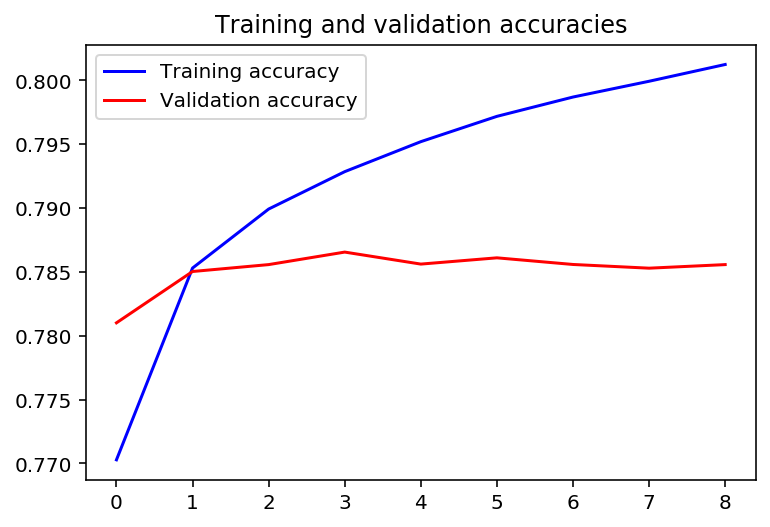

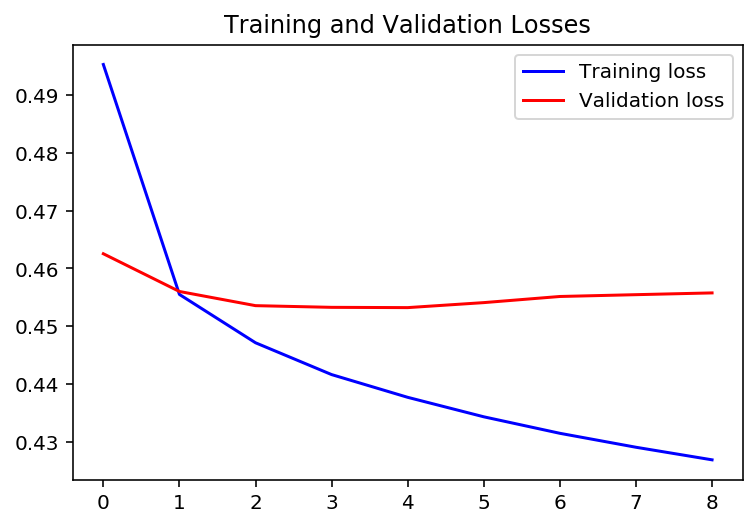

In [13]:
acc = history.history['acc']
validationAcc = history.history['val_acc']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, validationAcc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, trainingLoss, 'b', label='Training loss')
plt.plot(epochs, validationLoss, 'r', label='Validation loss')
plt.title('Training and Validation Losses')
plt.legend()
 
plt.show()

In [18]:
def sentimentScore(score):
        return "NEGATIVE" if score < 0.5 else "POSITIVE"

In [19]:
def evaluateTweet(Tweet):
    words = []
    tokens = Tweet.split() # Split each tweet into list of words.
    tokens = [word.lower() for word in tokens]
    tokens = filter(lambda x:x[0]!='@', tokens) # Remove mentions
    tokens = filter(lambda x:x[0]!='#', tokens) # Remove mentions
    tokens = [word.translate(table) for word in tokens] # Remove punctuation marks
    tokens = [word for word in tokens if word.isalpha()] # Remove any word that is not completely alphabetic.
    tokens = [word for word in tokens if not word in stopWords] # Remove any stopwords
    okens = [word for word in tokens if len(word) > 2] # Remove any word that is shorter than two letters
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Convert snowball words
    words.append(tokens)
#     flat_list = [item for sublist in l for item in sublist]
    return words

In [20]:
def predict(text, include_neutral=True):
    x_test = evaluateTweet(text)
    testFeatures = featureExtractor.transform(x_test[0]).toarray()
    score = model.predict([testFeatures])[0] # Get the score
    label = sentimentScore(score) # Predict based on the score

    return {"label": label, "score": float(score)}  

In [21]:
tweet = "I don't hate anyone"
print(evaluateTweet(tweet))
predict(tweet)

[['dont', 'hate', 'anyone']]


{'label': 'NEGATIVE',
 'score': 0.1586962342262268,
 'elapsed_time': 0.14387106895446777}

In [34]:
testData = pd.read_csv('Tweets.csv')
testFrame = testData[["airline_sentiment","text"]] # We only need Tweets and their corresponding polarities
testFrame = testFrame.drop(testFrame[testFrame['airline_sentiment'] == 'neutral'].index) # remove neutral tweets

testFrame = shuffle(testFrame) # Shuffle the data
testFrame.reset_index(inplace=True, drop=True)

testFrame = testFrame[:] # Pick n number of tweets. Note that DF is already shuffled. # pick


In [35]:
testFrame['airline_sentiment'] = testFrame['airline_sentiment'].replace(['positive','negative'],[1,0])

In [39]:
testTweets = []
for n in np.arange(testFrame.shape[0]):
    text = testFrame["text"][n]
    tokens = text.split() # Split each tweet into list of words.
    tokens = filter(lambda x:x[0]!='@', tokens) # Remove mentions
    tokens = [word for word in tokens if not word in stopWords] # Remove any stopwords
    tokens = [word.translate(table) for word in tokens] # Remove punctuation marks
    tokens = [word for word in tokens if word.isalpha()] # Remove any word that is not completely alphabetic.
    tokens = [word for word in tokens if len(word) > 1] # Remove any word that is shorter than two letters
    tokens = [word.lower() for word in tokens]
    testTweets.append(tokens)

In [40]:
testTweetSentences = []
for tweet in testTweets:
    testTweetSentences.append(' '.join(tweet))

In [41]:
testBagVectors = featureExtractor.transform(testTweetSentences).toarray()
testBagVectors.shape
len(testBagVectors)

11541

In [42]:
XTestAirline = testBagVectors
yTestAirline = testFrame['airline_sentiment']

In [43]:
# XTestAirline = np.reshape(XTestAirline, (XTestAirline.shape[0], 1, XTestAirline.shape[1]))

In [44]:
scores = model.evaluate(XTestAirline, yTestAirline, batch_size = 32)
print('Test accuracy:', scores[1])

11541/11541 [==============================] - 2s 193us/step
Test accuracy: 0.7683909539901221
